# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score

In [16]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [17]:
os.listdir(path + 'processed')

['processed_books.csv']

## Pull in required data:

In [18]:
df = pd.read_csv(path + 'processed/processed_books.csv')

In [19]:
df.shape

(37141, 21)

In [20]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.0,1,21.0,8.325719,2


### TF-IDF for Book Info:

In [21]:
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english')

In [22]:
tfidf_matrix = tf.fit(df['Book-Info'])

In [23]:
book_vector = tfidf_matrix.transform(df['Book-Info']).toarray()

In [24]:
df['Book-Vector'] = list(book_vector)

## Prepare model:

## Split into train and test set
also want to do cross validation to get mean of models

In [25]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Author-Processed', 'Book-Publisher-Processed',
       'Book-Title-Processed', 'Book-Info', 'Book-Vector',
       'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded',
       'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'weighted_ratings_group_encoded'],
      dtype='object')

In [26]:
X = df[['Book-Info', 'User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']]
y = df['weighted_ratings_group_encoded']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [28]:
X_train.head(1)

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
9148,song of solomon oprah s book club paperback by...,7,0,6


## Train Model

In [29]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english'))
])


# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']),
    ('country', 'passthrough', ['User-Country-Encoded'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

CPU times: user 21 µs, sys: 14 µs, total: 35 µs
Wall time: 48.9 µs


In [31]:
%%time
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

CPU times: user 19.3 s, sys: 415 ms, total: 19.7 s
Wall time: 20.4 s


In [40]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.40669695 0.40518257 0.41568495 0.40962639 0.40844833]


In [43]:
%%time
# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 4.88 s, sys: 41.4 ms, total: 4.92 s
Wall time: 4.98 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(min_df=0,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english'))]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group-Encoded',
                                                   'Year-Of-Publication-Group-Encoded']),
                                                 ('country', 'passthrough',
                                                  ['User-Country-Encoded'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [44]:
y_pred = pipeline.predict(X_test)

## Results

In [46]:
y_pred_train = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Accuracy: 0.9726373182552503
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8486
           1       0.97      0.97      0.97     11250
           2       1.00      0.95      0.98      9976

    accuracy                           0.97     29712
   macro avg       0.97      0.97      0.97     29712
weighted avg       0.97      0.97      0.97     29712

Confusion Matrix (Training Set):
[[ 8472     9     5]
 [  324 10915    11]
 [  188   276  9512]]


In [47]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.4143222506393862
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.38      0.33      0.35      2062
           1       0.41      0.48      0.44      2820
           2       0.45      0.41      0.43      2547

    accuracy                           0.41      7429
   macro avg       0.41      0.41      0.41      7429
weighted avg       0.41      0.41      0.41      7429

Confusion Matrix (Test Set):
[[ 680  886  496]
 [ 681 1352  787]
 [ 443 1058 1046]]


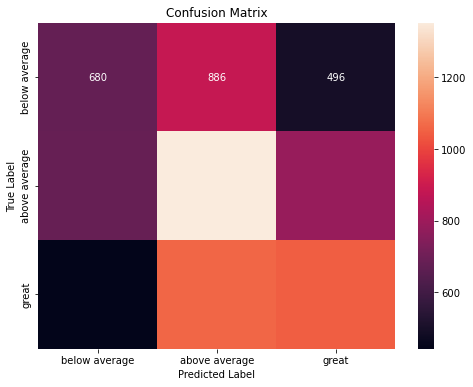

In [58]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
# issue with version of seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='d', annot = True,
            xticklabels=['below average', 'above average', 'great'],
            yticklabels=['below average', 'above average', 'great'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [59]:
cm

array([[ 680,  886,  496],
       [ 681, 1352,  787],
       [ 443, 1058, 1046]])

## Able to estimate popularity:

In [60]:
example_dict = {'Book-Info':'harry potter by jk rowling',
                          'User-Country-Encoded':65, 'Age-Group-Encoded':2,
                'Year-Of-Publication-Group-Encoded':7}

X_example = pd.DataFrame(example_dict, index = [0])
X_example

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
0,harry potter by jk rowling,65,2,7


In [62]:
# bins for weighted rating: 4.20336529, 7.57571908, 8.05047939, 9.51708247]
# between 8.050 and 9.517
# great
pipeline.predict(X_example)[0]

2

## Dataset info:

In [63]:
df[['Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded']].drop_duplicates()

,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,"(1989, 1999]",7
47,"(1999, 2009]",8
172,"(1979, 1989]",6
1588,"(1959, 1969]",4
1600,"(1969, 1979]",5
6028,"(1949, 1959]",3
22704,"(1929, 1939]",1


In [64]:
df[['Age-Group', 'Age-Group-Encoded']].drop_duplicates()

,Age-Group,Age-Group-Encoded
0,"(4.0, 26.0]",0
1,"(26.0, 34.0]",1
2,"(46.0, 100.0]",3
5,"(34.0, 46.0]",2


In [65]:
df[['User-Country', 'User-Country-Encoded']].drop_duplicates()

,User-Country,User-Country-Encoded
0,malaysia,65
1,unknown,121
3,usa,124
7,australia,7
8,brazil,15
...,...,...
27737,urugua,122
31652,croatia,25
33861,u.s.a.,115
34124,tajikistan,107


In [66]:
df['weighted_ratings_group_encoded'].drop_duplicates()

0    2
1    1
4    0
Name: weighted_ratings_group_encoded, dtype: int64